In [304]:
pip install fancyimpute

In [305]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from fancyimpute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,recall_score
import numpy as np
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

In [306]:
df=pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [307]:
df.info()
#there are missing values in bmi columns(201 missing values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [308]:
df.describe()
#note that min in Age is 0.08(which is weired, or we can that the age person's has not completed one year(in months))
#note that there is skewed (positive) in avg_glucose_level column, and in age column (negative)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [309]:
df.duplicated().sum()
#note that there is no duplicating rows

0

In [310]:
df.isnull().sum()
#as it was said before,there are missing values in bmi column(201->number of missing values)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [311]:
numerical_df = df.select_dtypes(include=['number'])
numerical_df = numerical_df [['age','avg_glucose_level','bmi'	]]
#the columns of DF will be divided into 2 parts to do data visualization

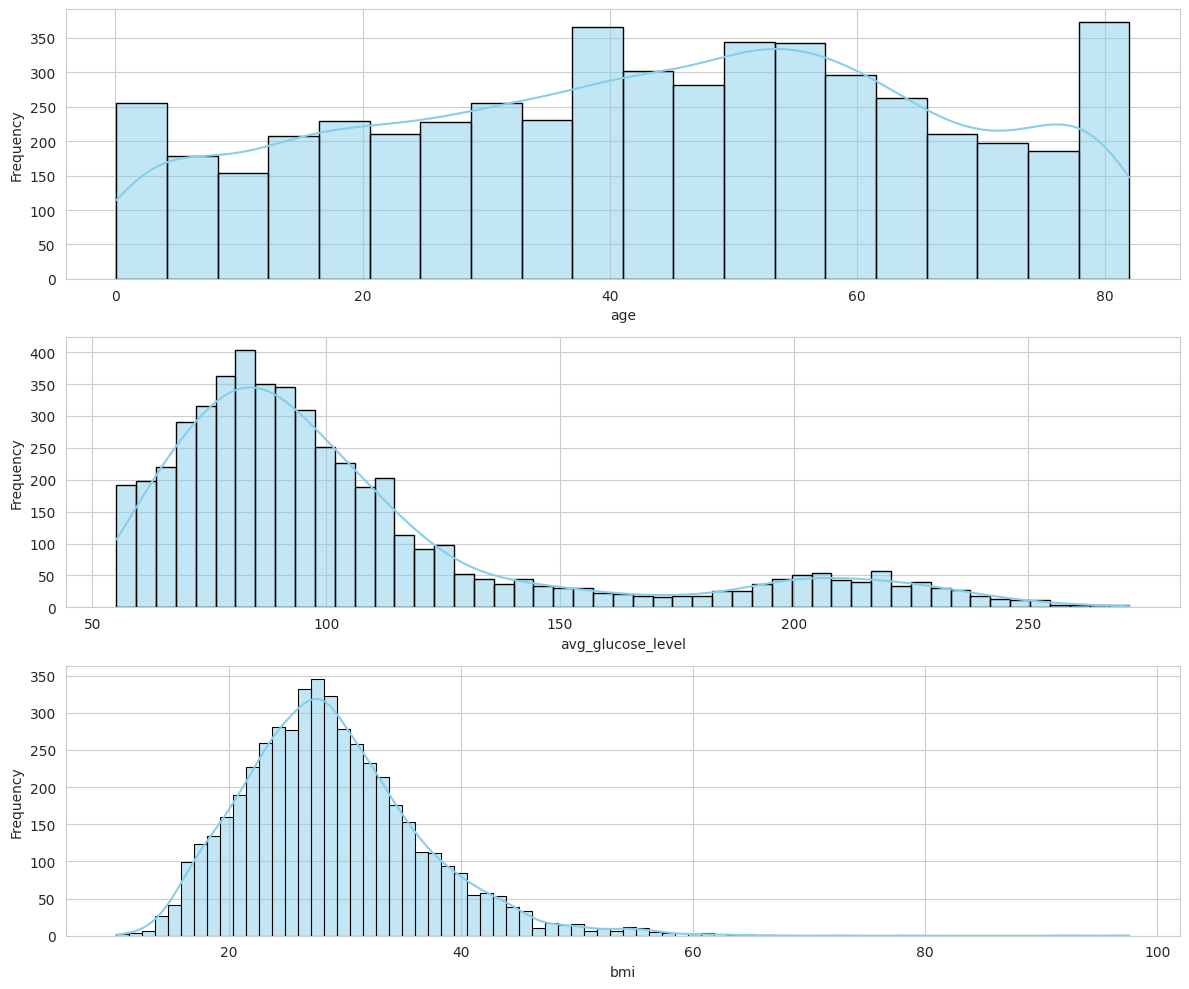

In [312]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

# Plot histograms for each numerical column
for i, column in enumerate(numerical_df.columns):
    sns.histplot(data=numerical_df, x=column, kde=True, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

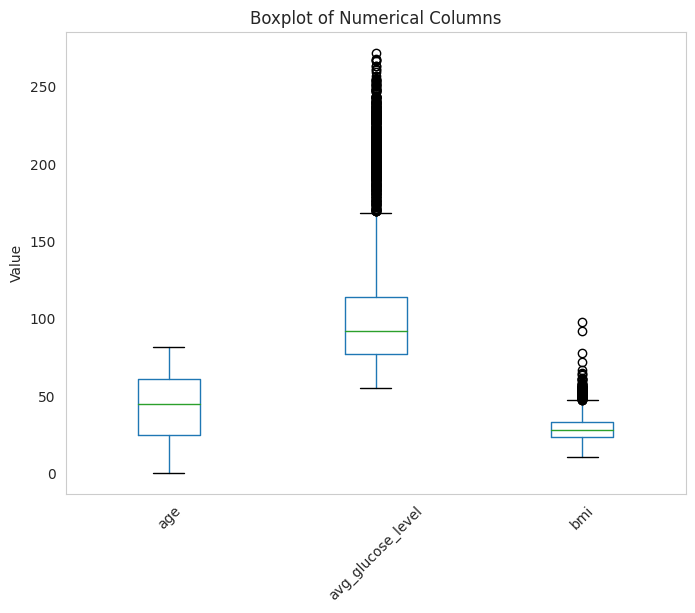

In [313]:
numerical_df.boxplot(figsize=(8, 6))
plt.title('Boxplot of Numerical Columns')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()
# note that there are outliers in bmi and avg_glucose_level columns

In [314]:
filtered_df = df[df['age'] < 1]
filtered_df['age'].value_counts().sum()
#note that there are 43 persons in DF,whose their age are less than 1 year

43

In [315]:
categorical_df = df.select_dtypes(include=['object', 'category'])
categorical_df["hypertension"] = df["hypertension"]
categorical_df["heart_disease"] = df["heart_disease"]
categorical_df["stroke"] = df["stroke"]
categorical_df

,gender,ever_married,work_type,Residence_type,smoking_status,hypertension,heart_disease,stroke
0,Male,Yes,Private,Urban,formerly smoked,0,1,1
1,Female,Yes,Self-employed,Rural,never smoked,0,0,1
2,Male,Yes,Private,Rural,never smoked,0,1,1
3,Female,Yes,Private,Urban,smokes,0,0,1
4,Female,Yes,Self-employed,Rural,never smoked,1,0,1
...,...,...,...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked,1,0,0
5106,Female,Yes,Self-employed,Urban,never smoked,0,0,0
5107,Female,Yes,Self-employed,Rural,never smoked,0,0,0
5108,Male,Yes,Private,Rural,formerly smoked,0,0,0


In [316]:
for column in categorical_df.columns:
    print(f"Value counts for {column}:")
    print(categorical_df[column].value_counts())
 # note that it is imbalance data(u can see that the number of people had a stroke are not the same number of peple who didn't have a stroke),and there are a lot of bias in DF
 # note that "Unknown" in smoking_status column is considered to be as missing values

Value counts for gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Value counts for ever_married:
Yes    3353
No     1757
Name: ever_married, dtype: int64
Value counts for work_type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Value counts for Residence_type:
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
Value counts for smoking_status:
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64
Value counts for hypertension:
0    4612
1     498
Name: hypertension, dtype: int64
Value counts for heart_disease:
0    4834
1     276
Name: heart_disease, dtype: int64
Value counts for stroke:
0    4861
1     249
Name: stroke, dtype: int64


In [317]:
#create a new df that has"Unknown"
unknown_smoking_df = df[df["smoking_status"] == "Unknown"]
unknown_smoking_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
23,64778,Male,82.0,0,1,Yes,Private,Rural,208.30,32.5,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5098,579,Male,9.0,0,0,No,children,Urban,71.88,17.5,Unknown,0
5101,36901,Female,45.0,0,0,Yes,Private,Urban,97.95,24.5,Unknown,0
5103,22127,Female,18.0,0,0,No,Private,Urban,82.85,46.9,Unknown,0
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0


In [318]:
#note that there are people whose their age are less than one year, so it will be the sign to tell us if we fill them properly if we fill them with never_smoked, because it is not realistic that they smoke
columns1=["gender", "age", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "avg_glucose_level", "bmi", "stroke"]
for col in columns1:
    print(unknown_smoking_df[col].value_counts())

Female    836
Male      708
Name: gender, dtype: int64
5.00    65
8.00    58
2.00    55
3.00    46
9.00    38
        ..
1.40     3
0.48     3
0.16     3
0.40     2
0.08     2
Name: age, Length: 104, dtype: int64
0    1492
1      52
Name: hypertension, dtype: int64
0    1496
1      48
Name: heart_disease, dtype: int64
No     901
Yes    643
Name: ever_married, dtype: int64
Private          640
children         618
Self-employed    156
Govt_job         122
Never_worked       8
Name: work_type, dtype: int64
Urban    782
Rural    762
Name: Residence_type, dtype: int64
84.10     4
83.91     3
78.24     3
76.74     3
93.74     3
         ..
118.21    1
149.42    1
136.10    1
100.82    1
85.28     1
Name: avg_glucose_level, Length: 1422, dtype: int64
19.5    16
18.6    16
18.0    16
29.1    13
23.4    13
        ..
43.8     1
12.3     1
48.9     1
36.0     1
46.9     1
Name: bmi, Length: 326, dtype: int64
0    1497
1      47
Name: stroke, dtype: int64


In [319]:
df['smoking_status'] = df['smoking_status'].replace('unknown', np.nan)

In [320]:
df.drop(df[df['gender'] == 'Other'].index, inplace=True)
#I'm going to drop the column which has "Other" gender,there is one row with one"Other" gender

In [321]:
#note that elder people are more likely to suffer from stroke than young people.
fig = px.histogram(df, x="age", color="stroke",
                   barmode="overlay", nbins=30,
                   labels={'Age': 'Age', 'count': 'Number of people who had astroke'},
                   title='stroke by Age ')

# Save the plot to an HTML file
fig.write_html("stroke by Age .html")
fig.show()

In [322]:
df.drop(columns=['id'],inplace=True,axis=1)
# id column is deleted

In [323]:
#to avoid data leakage, DF is split before any data preprocess by doing a stratified k-fold, because it is imbalanced data
#The common choice for cross-validation is k=5,especially that it is not a small df to use larger k
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = df.drop(columns=['stroke'])
y = df['stroke']
for fold_index, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [324]:
#as it was said before, there are missing values in bmi column, since there are outliers in the bmi column so the median method is used to fill them, I thought to delete them,specially there are 201 missing values, but there are 40 rows have missing values in the bmi column as the same time the value of stroke is 1 (which there are249 rows with 1 stroke)
train_median_bmi = X_train['bmi'].median()
X_train['bmi'].fillna(train_median_bmi, inplace=True)
test_median_bmi = X_test['bmi'].median()
X_test['bmi'].fillna(test_median_bmi, inplace=True)

<ipython-input-324-69893a073a19>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-324-69893a073a19>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [325]:
#note that gender,ever_married,work_type,Residence_type,smoking_status	columns need to encode them
#not that one hot encoding is used
#one hot encoding
#note that a parameter drop_first=True is used to get rid of multicollinearity,which can lead to issues in certain models, like logistic regression
X_train = pd.get_dummies(X_train, columns = ['gender','ever_married','work_type','Residence_type'],drop_first=True)
X_test = pd.get_dummies(X_test, columns = ['gender','ever_married','work_type','Residence_type'],drop_first=True)

In [326]:
#map function is used to encode smoking_status column(ordinal),label encoding was not recommended,because there are missing values in this column(I  had a pb when I used it, because it gave a number for missing values,which I  couldn't apply any method to fill them,so map function was the best way to encode them)
X_train['smoking_status_encoded'] = X_train['smoking_status'].map({'formerly smoked':2,'smokes': 1, 'never smoked': 0})
X_test['smoking_status_encoded'] = X_test['smoking_status'].map({'formerly smoked':2,'smokes': 1, 'never smoked': 0})
X_train.drop(columns=['smoking_status'], inplace=True)
X_test.drop(columns=['smoking_status'], inplace=True)

In [327]:
#there is in smoking_status column value with 'Unknown' which it is considered to be a missing values ,so we will deal with them
#The first method was used is knn
#note that we only fit the training data to make sure the training and testing data frames will have taken the same numerical value of each category, on the training data is fitted instead of the testing df to avoid data leakage
imputer = KNNImputer(n_neighbors=2)
X_train_imputed_values = imputer.fit_transform(X_train)
X_test_imputed_values = imputer.transform(X_test)
X_train_imputed = pd.DataFrame(X_train_imputed_values, columns=X_train.columns).round(0)
X_test_imputed = pd.DataFrame(X_test_imputed_values, columns=X_test.columns).round(0)

In [328]:
X_train_imputed['smoking_status_encoded'].value_counts()

0.0    2263
1.0     954
2.0     871
Name: smoking_status_encoded, dtype: int64

In [329]:
X_train['smoking_status_encoded'].value_counts()

0.0    1526
2.0     695
1.0     628
Name: smoking_status_encoded, dtype: int64

In [330]:
#note that when knn was used, the result shows that can predicted that some of the babies are smoking, which is not realistic
X_train_imputed[X_train_imputed['age']<1]

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_encoded
455,0.0,0.0,0.0,74.0,16.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
791,0.0,0.0,0.0,119.0,16.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
875,0.0,0.0,0.0,56.0,16.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1279,0.0,0.0,0.0,110.0,14.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1286,0.0,0.0,0.0,140.0,14.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1625,0.0,0.0,0.0,73.0,28.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
2323,0.0,0.0,0.0,58.0,19.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2640,0.0,0.0,0.0,70.0,17.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2712,0.0,0.0,0.0,89.0,14.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2901,0.0,0.0,0.0,115.0,17.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [331]:
#The second method is using MICE to fill missing values in the "smoking_status_encoded" column

imputer = IterativeImputer(random_state=42)
X_train_imputed1 = imputer.fit_transform(X_train)
X_test_imputed1 = imputer.transform(X_test)
# Convert imputed values back to DataFrame
X_train_imputed1 = pd.DataFrame(X_train_imputed1, columns=X_train.columns)
X_test_imputed1 = pd.DataFrame(X_test_imputed1, columns=X_test.columns)
X_train_imputed1['smoking_status_encoded']=X_train_imputed1['smoking_status_encoded'].round(0)
X_test_imputed1['smoking_status_encoded'] = X_test_imputed1['smoking_status_encoded'].round(0)

In [332]:
X_train_imputed1['smoking_status_encoded'].value_counts()

0.0    2099
1.0    1294
2.0     695
Name: smoking_status_encoded, dtype: int64

In [333]:
#note that the smoking_status for babies are never_smoked(0),which is it relastic result
X_train_imputed1[X_train_imputed1['age']<1]

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_encoded
296,0.64,0.0,0.0,83.82,24.9,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
305,0.88,0.0,0.0,88.11,15.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
455,0.32,0.0,0.0,73.71,16.2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
779,0.88,0.0,0.0,157.57,19.2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
791,0.24,0.0,0.0,118.87,16.3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
875,0.32,0.0,0.0,55.86,16.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
972,0.72,0.0,0.0,66.36,23.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1062,0.80,0.0,0.0,98.67,17.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1279,0.40,0.0,0.0,109.56,14.3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1286,0.08,0.0,0.0,139.67,14.1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [334]:
#feature scaling
scaler = MinMaxScaler()
scale_cols = ['age', 'avg_glucose_level']
scaler.fit(X_train[scale_cols])
X_train_imputed1[scale_cols] = scaler.transform(X_train[scale_cols])
X_test_imputed1[scale_cols] = scaler.transform(X_test[scale_cols])

In [335]:
#standscaler is used for "bmi" column,dut to it is normal distributed
scaler = StandardScaler()
scaler.fit(X_train[['bmi']])
X_train_imputed1['bmi_standardized'] = scaler.transform(X_train[['bmi']])
X_test_imputed1['bmi_standardized'] = scaler.transform(X_test[['bmi']])

In [336]:
#The only models are used are these 5 models(it is a machine learning final project),and recall will be used to see the accuracy of the model( it is more important to reduce false negatives)
#I would prefer to use class weight method to deal with imbalanced, but knn and naive bayes don't work with class weight method(don't support the class_weight parameter)
logistic_model = LogisticRegression(class_weight='balanced')
svc_model = SVC(class_weight='balanced')
decision_tree_model = DecisionTreeClassifier(class_weight='balanced')
knn_model = KNeighborsClassifier()
naive_bayes_model = GaussianNB()

In [337]:
# SMOTE is used to deal imbalanced with knn and naive bayes(they don't work with class weight)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed1, y_train)

In [338]:
logistic_model.fit(X_train_imputed1, y_train)
svc_model.fit(X_train_imputed1, y_train)
decision_tree_model.fit(X_train_imputed1, y_train)
knn_model.fit(X_train_resampled, y_train_resampled)
naive_bayes_model.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



GaussianNB()

In [339]:
y_pred_logistic = logistic_model.predict(X_test_imputed1)
y_pred_svc = svc_model.predict(X_test_imputed1)
y_pred_decision_tree = decision_tree_model.predict(X_test_imputed1)
y_pred_knn = knn_model.predict(X_test_imputed1)
y_pred_naive_bayes= naive_bayes_model.predict(X_test_imputed1)

In [340]:
# Compute confusion matrices
confusion_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)
confusion_matrix_svc = confusion_matrix(y_test, y_pred_svc)
confusion_matrix_decision_tree = confusion_matrix(y_test, y_pred_decision_tree)
confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)
confusion_matrix_naive_bayes = confusion_matrix(y_test, y_pred_naive_bayes)

# Print the confusion matrices
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix_logistic)
print("\nConfusion Matrix for Support Vector Classifier:")
print(confusion_matrix_svc)
print("\nConfusion Matrix for Decision Tree Classifier:")
print(confusion_matrix_decision_tree)
print("\nConfusion Matrix for KNN Classifier:")
print(confusion_matrix_knn)
print("\nConfusion Matrix for Naive Bayes:")
print(confusion_matrix_naive_bayes)


Confusion Matrix for Logistic Regression:
[[716 256]
 [ 13  36]]

Confusion Matrix for Support Vector Classifier:
[[535 437]
 [  9  40]]

Confusion Matrix for Decision Tree Classifier:
[[933  39]
 [ 48   1]]

Confusion Matrix for KNN Classifier:
[[817 155]
 [ 33  16]]

Confusion Matrix for Naive Bayes:
[[352 620]
 [  1  48]]


In [341]:
recall_logistic = recall_score(y_test, y_pred_logistic)
recall_svc = recall_score(y_test, y_pred_svc)
recall_decision_tree = recall_score(y_test, y_pred_decision_tree)
recall_knn = recall_score(y_test, y_pred_knn)
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes)

# Print recall scores
print("Recall Score for Logistic Regression:", recall_logistic)
print("Recall Score for Support Vector Classifier:", recall_svc)
print("Recall Score for Decision Tree Classifier:", recall_decision_tree)
print("Recall Score for KNN Classifier:", recall_knn)
print("Recall Score for Naive Bayes:", recall_naive_bayes)

Recall Score for Logistic Regression: 0.7346938775510204
Recall Score for Support Vector Classifier: 0.8163265306122449
Recall Score for Decision Tree Classifier: 0.02040816326530612
Recall Score for KNN Classifier: 0.32653061224489793
Recall Score for Naive Bayes: 0.9795918367346939


In [342]:
#The best recall is for Naive Bayes and then SVR,but FP is less than in SVR ,note that DS model have a lot bias toward stroke 0(u could use class weight manually or anther method to deal with imbalanced problem)
#the last step is saving a model '-'
import joblib
joblib.dump(naive_bayes_model, 'naive_bayes_model.pkl')

['naive_bayes_model.pkl']